# Face recognition
All code has been slightly adapted from the following tutorial on [PyImageSearch.com](https://www.pyimagesearch.com/):
  - OpenCV face recognition (**[tutorial link](https://www.pyimagesearch.com/2018/09/24/opencv-face-recognition/)**)
  
Recognizing faces in images requires a two-step approach:
  1. Face **detection**: detect the _presence_ and location of a face in an image
  2. Face **classification**: classify _whose_ face is in the detected part of an image

---
# 1. Train face classifier
The face detector has already been trained to detect faces in images, so that doesn't need any re-training or anything like that.

The first step is for us to train a classifier to say _whose_ face is found within the detected regions of an image.

To do this, the following steps need to be taken:
  1. Detect the locations of faces in our training images using pre-trained face detection model
  2. Transform faces into 128-d embeddings using pre-trained embedding model
  3. Train SVM to classify the embeddings

## 1.1. Extract embeddings
To train the SVM, we need to generate some training data from the images we have. This requires us to use both pre-trained models to first detect the faces, then extract embeddings from the faces.

In [1]:
from tqdm.notebook import tqdm
from imutils import paths
import numpy as np
import imutils
import pickle
import cv2
import os

In [2]:
# globals
DATASET = 'dataset'                    # path to input directory of faces + images
EMBEDDINGS = 'output/embeddings.pkl'   # path to output serialized db of facial embeddings
DETECTOR = 'face_detection_model/'     # path to OpenCV's deep learning face detector
EMBEDDING_MODEL = 'embedding_model/'   # path to OpenCV's deep learning face embedding model
CONFIDENCE = .5                        # minimum probability to filter weak detections

#### Load pre-trained face detector
When using OpenCV’s deep neural network module with Caffe models, you’ll need two sets of files:

  - The `.prototxt` file(s) which define the model architecture (i.e., the layers themselves)
  - The `.caffemodel` file which contains the weights for the actual layers

In [3]:
# load our serialized face detector from disk
print('Loading face detector...')
detector = cv2.dnn.readNetFromCaffe(
    prototxt=DETECTOR+'deploy.prototxt',
    caffeModel=DETECTOR+'res10_300x300_ssd_iter_140000.caffemodel'
)

Loading face detector...


#### Load pre-trained embedding model

In [4]:
# load our serialized face embedding model from disk
print("Loading face recognizer...")
embedder = cv2.dnn.readNetFromTorch(EMBEDDING_MODEL+'openface_nn4.small2.v1.t7')

Loading face recognizer...


#### Extract embeddings of all images
```
for each image:

    detect location of face(s) (it is assumed each training image contains just one face)

    if multiple faces found:
    
        choose region with highest confidence
        
        extract embeddings
```

In [5]:
# grab the paths to the input images in our dataset
print("Quantifying faces...")
imagePaths = list(paths.list_images(DATASET))

# initialize our lists of extracted facial embeddings and
# corresponding people names
knownEmbeddings = []
knownNames = []

# initialize the total number of faces processed
total = 0

# loop over the image paths
for imagePath in tqdm(imagePaths):
    name = imagePath.split(os.path.sep)[-2]

    # load the image, resize it to have a width of 600 pixels (while
    # maintaining the aspect ratio), and then grab the image
    # dimensions
    image = cv2.imread(imagePath)
    image = imutils.resize(image, width=600)
    h, w = image.shape[:2]

    # construct a blob from the image
    imageBlob = cv2.dnn.blobFromImage(
        cv2.resize(image, (300, 300)), 1.0, (300, 300),
        (104.0, 177.0, 123.0), swapRB=False, crop=False
    )

    # apply OpenCV's deep learning-based face detector to localize
    # faces in the input image
    detector.setInput(imageBlob)
    detections = detector.forward()

    # ensure at least one face was found
    if len(detections) > 0:
        # we're making the assumption that each image has only ONE
        # face, so find the bounding box with the largest probability
        i = np.argmax(detections[0, 0, :, 2])
        confidence = detections[0, 0, i, 2]

        # ensure that the detection with the largest probability also
        # means our minimum probability test (thus helping filter out
        # weak detections)
        if confidence > CONFIDENCE:
            # compute the (x, y)-coordinates of the bounding box for
            # the face
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            startX, startY, endX, endY = box.astype("int")

            # extract the face ROI and grab the ROI dimensions
            face = image[startY:endY, startX:endX]
            fH, fW = face.shape[:2]

            # ensure the face width and height are sufficiently large
            if fW < 20 or fH < 20:
                continue

            # construct a blob for the face ROI, then pass the blob
            # through our face embedding model to obtain the 128-d
            # quantification of the face
            faceBlob = cv2.dnn.blobFromImage(face, 1.0 / 255,
                (96, 96), (0, 0, 0), swapRB=True, crop=False)
            embedder.setInput(faceBlob)
            vec = embedder.forward()

            # add the name of the person + corresponding face
            # embedding to their respective lists
            knownNames.append(name)
            knownEmbeddings.append(vec.flatten())
            total += 1

# dump the facial embeddings + names to disk
print("Serializing {} encodings...".format(total))
data = {"embeddings": knownEmbeddings, "names": knownNames}
f = open(EMBEDDINGS, "wb")
f.write(pickle.dumps(data))
f.close()
print("Done")

Quantifying faces...



Serializing 25 encodings...
Done


## 1.2. Train face classifier
Now, with the embeddings extracted and labelled in our pickle file. The next step is to train a support vector machine to classify the embeddings, so that when we spot a face in an image, we can say who that belongs to!

In [6]:
# import the necessary packages
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
import matplotlib.pyplot as plt

In [7]:
# globals
RECOGNIZER = 'output/recognizer.pkl'  # path to output model trained to recognize faces
LE = 'output/le.pkl'                  # path to output label encoder

In [8]:
# load the face embeddings
print("Loading face embeddings...")
data = pickle.loads(open(EMBEDDINGS, "rb").read())

# encode the labels
print("Encoding labels...")
le = LabelEncoder()
labels = le.fit_transform(data["names"])

# train the model used to accept the 128-d embeddings of the face and
# then produce the actual face recognition
print("Training model...")
recognizer = SVC(C=1.0, kernel="linear", probability=True)
recognizer.fit(data["embeddings"], labels)

# write the actual face recognition model to disk
f = open(RECOGNIZER, "wb")
f.write(pickle.dumps(recognizer))
f.close()

# write the label encoder to disk
f = open(LE, "wb")
f.write(pickle.dumps(le))
f.close()

Loading face embeddings...
Encoding labels...
Training model...


---
# 2. Detect and recognize faces
Let's test out all the components together now. Using an image we have saved on disk, we will do the following:
  1. Use detector to get location of face
  2. Extract embeddings from face
  3. Classify embeddings to determine owner of face

In [9]:
# globals
IMAGE = 'images/james.jpg'  # path to input image

In [10]:
# load our serialized face detector from disk
print("Loading face detector...")
detector = cv2.dnn.readNetFromCaffe(
    prototxt=DETECTOR+'deploy.prototxt',
    caffeModel=DETECTOR+'res10_300x300_ssd_iter_140000.caffemodel'
)

# load our serialized face embedding model from disk
print("Loading face recognizer...")
embedder = cv2.dnn.readNetFromTorch(EMBEDDING_MODEL+'openface_nn4.small2.v1.t7')

# load the actual face recognition model along with the label encoder
recognizer = pickle.loads(open(RECOGNIZER, "rb").read())
le = pickle.loads(open(LE, "rb").read())

Loading face detector...
Loading face recognizer...


In [11]:
# load the image, resize it to have a width of 600 pixels (while
# maintaining the aspect ratio), and then grab the image dimensions
image = cv2.imread(IMAGE)
image = imutils.resize(image, width=600)
(h, w) = image.shape[:2]

# construct a blob from the image
imageBlob = cv2.dnn.blobFromImage(
    cv2.resize(image, (300, 300)), 1.0, (300, 300),
    (104.0, 177.0, 123.0), swapRB=False, crop=False)

# apply OpenCV's deep learning-based face detector to localize
# faces in the input image
detector.setInput(imageBlob)
detections = detector.forward()


james: 75.69%


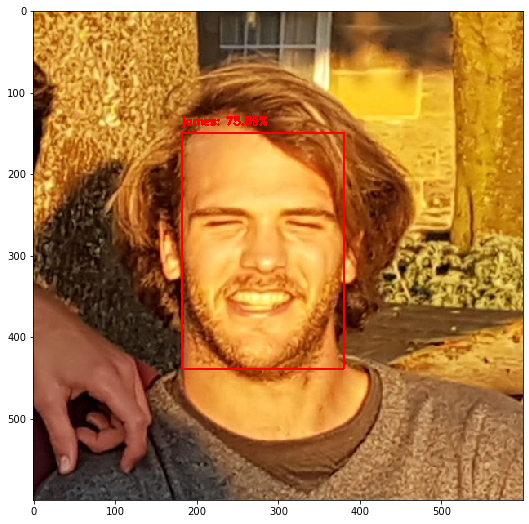

In [12]:
# loop over the detections
for i in tqdm(range(0, detections.shape[2])):
    # extract the confidence (i.e., probability) associated with the
    # prediction
    confidence = detections[0, 0, i, 2]

    # filter out weak detections
    if confidence > CONFIDENCE:
        # compute the (x, y)-coordinates of the bounding box for the
        # face
        box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
        (startX, startY, endX, endY) = box.astype("int")

        # extract the face ROI
        face = image[startY:endY, startX:endX]
        (fH, fW) = face.shape[:2]

        # ensure the face width and height are sufficiently large
        if fW < 20 or fH < 20:
            continue

        # construct a blob for the face ROI, then pass the blob
        # through our face embedding model to obtain the 128-d
        # quantification of the face
        faceBlob = cv2.dnn.blobFromImage(face, 1.0 / 255, (96, 96),
            (0, 0, 0), swapRB=True, crop=False)
        embedder.setInput(faceBlob)
        vec = embedder.forward()

        # perform classification to recognize the face
        preds = recognizer.predict_proba(vec)[0]
        j = np.argmax(preds)
        proba = preds[j]
        name = le.classes_[j]

        # draw the bounding box of the face along with the associated
        # probability
        text = "{}: {:.2f}%".format(name, proba * 100)
        y = startY - 10 if startY - 10 > 10 else startY + 10
        cv2.rectangle(image, (startX, startY), (endX, endY),
            (0, 0, 255), 2)
        cv2.putText(image, text, (startX, y),
            cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)

print(text)
# show the output image
plt.figure(figsize=(9,9))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

---
# 3. Webcam detection
Finally, here's an implementation of everything in real time.

In [13]:
from imutils.video import VideoStream
from imutils.video import FPS
import time

In [14]:
# load our serialized face detector from disk
print("Loading face detector...")
detector = cv2.dnn.readNetFromCaffe(
    prototxt=DETECTOR+'deploy.prototxt',
    caffeModel=DETECTOR+'res10_300x300_ssd_iter_140000.caffemodel'
)

# load our serialized face embedding model from disk
print("Loading face recognizer...")
embedder = cv2.dnn.readNetFromTorch(EMBEDDING_MODEL+'openface_nn4.small2.v1.t7')

# load the actual face recognition model along with the label encoder
recognizer = pickle.loads(open(RECOGNIZER, "rb").read())
le = pickle.loads(open(LE, "rb").read())

Loading face detector...
Loading face recognizer...


In [15]:
# initialize the video stream, then allow the camera sensor to warm up
print("Starting video stream...")
vs = VideoStream(src=0).start()
time.sleep(2.0)

# start the FPS throughput estimator
fps = FPS().start()

# loop over frames from the video file stream
while True:
    # grab the frame from the threaded video stream
    frame = vs.read()

    # resize the frame to have a width of 600 pixels (while
    # maintaining the aspect ratio), and then grab the image
    # dimensions
    frame = imutils.resize(frame, width=600)
    (h, w) = frame.shape[:2]

    # construct a blob from the image
    imageBlob = cv2.dnn.blobFromImage(
        cv2.resize(frame, (300, 300)), 1.0, (300, 300),
        (104.0, 177.0, 123.0), swapRB=False, crop=False)

    # apply OpenCV's deep learning-based face detector to localize
    # faces in the input image
    detector.setInput(imageBlob)
    detections = detector.forward()

    # loop over the detections
    for i in range(0, detections.shape[2]):
        # extract the confidence (i.e., probability) associated with
        # the prediction
        confidence = detections[0, 0, i, 2]

        # filter out weak detections
        if confidence > CONFIDENCE:
            # compute the (x, y)-coordinates of the bounding box for
            # the face
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")

            # extract the face ROI
            face = frame[startY:endY, startX:endX]
            (fH, fW) = face.shape[:2]

            # ensure the face width and height are sufficiently large
            if fW < 20 or fH < 20:
                continue

            # construct a blob for the face ROI, then pass the blob
            # through our face embedding model to obtain the 128-d
            # quantification of the face
            faceBlob = cv2.dnn.blobFromImage(face, 1.0 / 255,
                (96, 96), (0, 0, 0), swapRB=True, crop=False)
            embedder.setInput(faceBlob)
            vec = embedder.forward()

            # perform classification to recognize the face
            preds = recognizer.predict_proba(vec)[0]
            j = np.argmax(preds)
            proba = preds[j]
            name = le.classes_[j]

            # draw the bounding box of the face along with the
            # associated probability
            text = "{}: {:.2f}%".format(name, proba * 100)
            y = startY - 10 if startY - 10 > 10 else startY + 10
            cv2.rectangle(frame, (startX, startY), (endX, endY),
                (0, 0, 255), 2)
            cv2.putText(frame, text, (startX, y),
                cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)

    # update the FPS counter
    fps.update()

    # show the output frame
    cv2.imshow("Frame", frame)
    key = cv2.waitKey(1) & 0xFF

    # if the `q` key was pressed, break from the loop
    if key == ord("q"):
        break

# stop the timer and display FPS information
fps.stop()
print("Elasped time: {:.2f}".format(fps.elapsed()))
print("Approx. FPS: {:.2f}".format(fps.fps()))

# do a bit of cleanup
cv2.destroyAllWindows()
vs.stop()

Starting video stream...
Elasped time: 5.49
Approx. FPS: 16.57
